In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm
from tifffile import imsave
import torchvision.transforms as T
from PIL import Image
import nibabel as nib

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

2024-05-04 03:59:58.393659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 03:59:58.393817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 03:59:58.680150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.4.dev2417
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 512154add7a0d66f50a2689006c9e91c7aceeace
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp6m4uxdft


In [4]:
import pickle
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [5]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_train.pkl', 'rb') as f:
    t_data = pd.read_pickle(f)


In [6]:
with open('/kaggle/input/lung-cancer-pkl-file/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_test.pkl', 'rb') as f:
    v_data = pd.read_pickle(f)


In [7]:
t_data

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
703,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1015.0, -1024.0, -972.0, -975.0, -1013.0, -..."
704,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1022.0, -1024.0, -957.0, -987.0, -1022.0, -..."
705,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -951.0, -998.0, -1019.0, -..."
706,LR4B,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1009.0, -968.0, -1022.0, -1007.0, ..."


In [8]:
v_data

,label1,mask,hu_array,hu_array_old
0,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
1,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
2,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
3,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
4,LR2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0,..."
...,...,...,...,...
259,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
260,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
261,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
262,LR3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."


In [61]:
t_data["hu_array"][0].max()

815.0

In [62]:
t_data["hu_array"][0].min()

-1024.0

In [9]:
def NormalizerHu(matrix): #Normalize our data image

    matrix = (matrix - matrix.min())/(matrix.max()- matrix.min())

    return matrix



In [17]:
data["hu_array_old"][0]

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       ...,
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]])

In [18]:
NormalizerHu(data["hu_array_old"][0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
norm_t_data = []
for i, j in enumerate(t_data["hu_array_old"]):
  n = NormalizerHu(t_data["hu_array_old"][i])
  norm_t_data.append(n)

norm_t_data = np.array(norm_t_data)

In [11]:
norm_v_data = []
for i, j in enumerate(v_data["hu_array_old"]):
  n = NormalizerHu(v_data["hu_array_old"][i])
  norm_v_data.append(n)

norm_v_data = np.array(norm_v_data)

Since we are going to be using the UNET-R architecture, we will need to split each 3-D image into voxels, by first splitting each image into seperate 16x16 images

Since our input is of LxWxHxC, we must deduce the height(depth) of each image

In [22]:
k = 1
init = data["label1"][0]
for i,j in enumerate(data["label1"]):
  if (init != j):
    print(k)
    init = j
    k = 1
  else:
    k = k + 1




33
35
12
15
12
15
10
28
35
10
4
90
18
8
5
6
27
27
6
8
7
4
5
1
3
14
5
3
18


It seems that our CT scans have variable depths. This means that we need to create an algorithm that can normalize the CT scan images and image segments based on their volumes

In [12]:
t_labels = []
for i in t_data['mask']:
  t_labels.append(i)

t_labels= np.array(t_labels)


In [13]:
v_labels = []
for i in v_data['mask']:
  v_labels.append(i)

v_labels= np.array(t_labels)


In [14]:
import shutil

In [15]:
parent_dir = '/kaggle/working/'
directory = 'NII Training_Images'
t_PATH = os.path.join(parent_dir, directory) 
os.mkdir(t_PATH)

In [16]:
directory = 'NII Valid_Images'
v_PATH = os.path.join(parent_dir, directory) 
os.mkdir(v_PATH)

In [17]:
t_labels = t_labels.astype(float)
v_labels = v_labels.astype(float)

In [69]:
shutil.rmtree(v_PATH)
shutil.rmtree(t_PATH)

In [18]:
k = 0
start = 0
file_pos = 0
train_dict_list = []
init = t_data["label1"][0]
for i,j in enumerate(t_data["label1"]):
  if (init != j):
     f_images = nib.Nifti2Image(norm_t_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(t_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 1):
      nib.save(f_images, os.path.join(t_PATH, 'train_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(t_PATH, 'train_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [19]:
k = 0
start = 0
file_pos = 0
valid_dict_list = []
init = v_data["label1"][0]
for i,j in enumerate(v_data["label1"]):
  if (init != j ):
     f_images = nib.Nifti2Image(norm_v_data[start:k, :, :], affine=np.eye(4))
     f_labels = nib.Nifti2Image(v_labels[start:k, :, :], affine=np.eye(4))
     if(k-start > 1):
      nib.save(f_images, os.path.join(v_PATH, 'valid_image' + str(file_pos)+ '.nii.gz'))
      nib.save(f_labels, os.path.join(v_PATH, 'valid_label' + str(file_pos)+ '.nii.gz'))
      file_pos = file_pos + 1
     init = j
     start = k
  else:
    k = k + 1

In [21]:
os.listdir(v_PATH)

['valid_label5.nii.gz',
 'valid_image1.nii.gz',
 'valid_label4.nii.gz',
 'valid_image5.nii.gz',
 'valid_label1.nii.gz',
 'valid_image2.nii.gz',
 'valid_label2.nii.gz',
 'valid_label0.nii.gz',
 'valid_label3.nii.gz',
 'valid_image0.nii.gz',
 'valid_image6.nii.gz',
 'valid_image4.nii.gz',
 'valid_image3.nii.gz',
 'valid_label6.nii.gz']

In [20]:
valid_dict_list = []
train_dict_list =[]

In [21]:
for files in range(len(os.listdir(t_PATH))//2):
  training = {
      "image": os.path.join(t_PATH, 'train_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(t_PATH, 'train_label' + str(files)+ '.nii.gz')
  }
  train_dict_list.append(training)

In [22]:
for files in range(len(os.listdir(v_PATH))//2):
  validation = {
      "image": os.path.join(v_PATH, 'valid_image' + str(files)+ '.nii.gz'),
      "label":  os.path.join(v_PATH, 'valid_label' + str(files)+ '.nii.gz')
  }
  valid_dict_list.append(validation)

In [11]:
train_dict_list

[{'image': '/kaggle/working/NII Training_Images/train_image0.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label0.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image1.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label1.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image2.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label2.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image3.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label3.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image4.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label4.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image5.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label5.nii.gz'},
 {'image': '/kaggle/working/NII Training_Images/train_image6.nii.gz',
  'label': '/kaggle/working/NII Training_Images/train_label6.nii.gz'},
 {'image': '/

In [23]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
           keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
          Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128)
          ),
       CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96,96,96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Resized(
           keys = ["image", "label"],
           spatial_size = (128,128,128)
          ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [24]:
train_ds = CacheDataset(
    data=train_dict_list,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)

Loading dataset: 100%|██████████| 24/24 [00:09<00:00,  2.42it/s]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
val_ds = CacheDataset(data=valid_dict_list, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]


In [73]:
recon_image =  next(iter(val_loader))
label_image = train_loader

In [77]:
recon_image['image'][0].shape

torch.Size([1, 128, 128, 128])

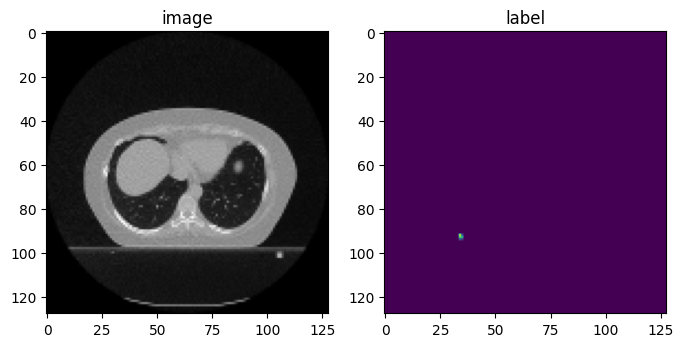

In [78]:

plt.figure("visualize", (8, 4))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(recon_image['image'][0][0,1,:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(recon_image['label'][0][0,1,:,:])
plt.show()

In [26]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=2,
    img_size=(96,96,96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

/opt/conda/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


In [27]:
model

UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Sequential(
        (0): Rearrange('b c (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3 c)', p1=16, p2=16, p3=16)
        (1): Linear(in_features=4096, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b

In [28]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)

            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))  # noqa: B038
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(  # noqa: B038
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/kaggle/working/", "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 500
eval_num = 500
post_label = AsDiscrete(to_onehot=2)
post_pred = AsDiscrete(argmax=True, to_onehot=2)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/kaggle/working/", "best_metric_model.pth")))

Training (500 / 500 Steps) (loss=0.76468):  89%|████████▉ | 25/28 [00:36<00:09,  3.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.49984246492385864 Current Avg. Dice: 0.49984246492385864


Training (503 / 500 Steps) (loss=0.76421): 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]


<All keys matched successfully>

In [31]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")


train completed, best_metric: 0.4998 at iteration: 500


[0.7688844752311706]


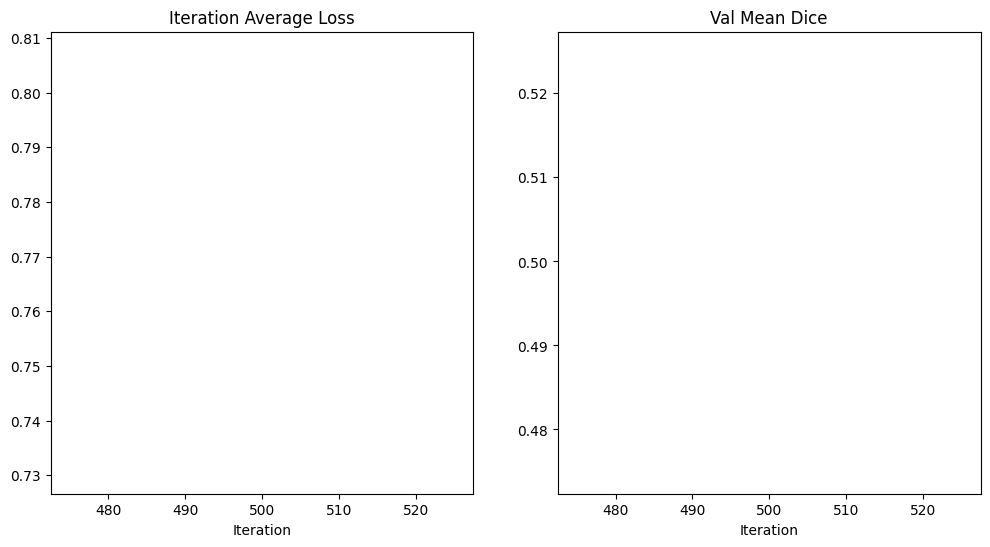

In [32]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

(1, 1, 128, 128, 128)
torch.Size([1, 128, 128, 128])


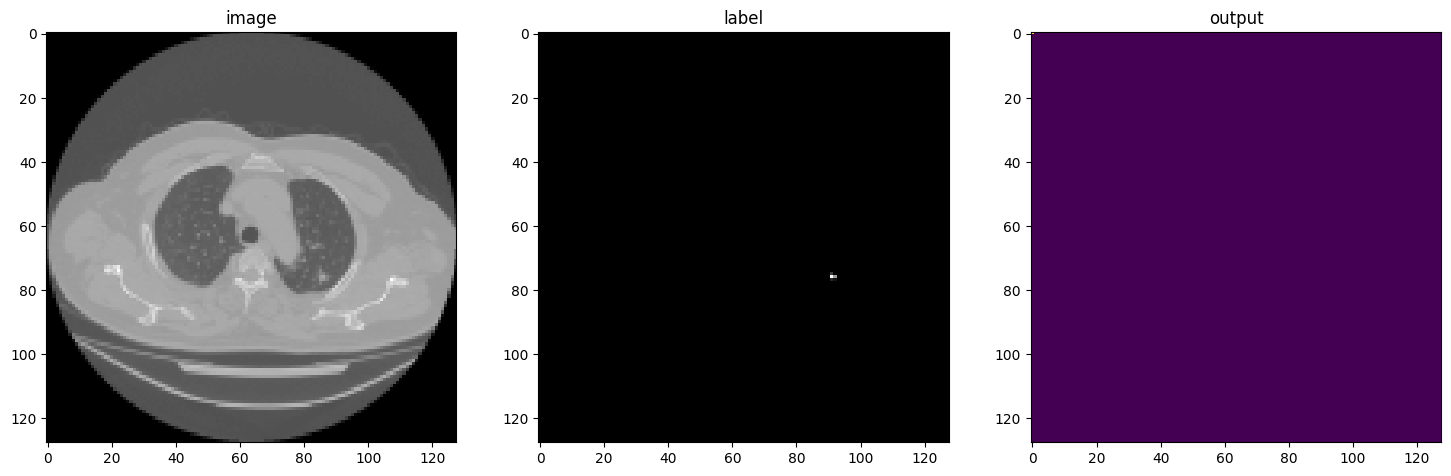

In [62]:
case_num = 4
model.load_state_dict(torch.load(os.path.join("/kaggle/working/", "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    print(val_labels.cpu().numpy().shape)
    print(torch.argmax(val_outputs, dim=1).shape)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, 0, :, :], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, 0, :, :], cmap="gray")
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, 0, :, :])
    plt.show()